In [1]:
import os
import sys
import gains as genetic
import pandas as pd
import rdkit
import pickle
from math import exp
import numpy as np
import random
import unittest
import datetime
import sys
import sklearn

from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator

%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function
from os.path import dirname, join
import pandas as pd
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit.Chem import AllChem as Chem
import pickle
import os
import statistics
import time
import random
import sys
# uncomment once due is setup
# from .due import due, Doi
# Use duecredit (duecredit.org) to provide a citation to relevant work to
# be cited. This does nothing, unless the user has duecredit installed,
# And calls this with duecredit (as in `python -m duecredit script.py`):
# due.cite(Doi("10.1167/13.9.30"),
#         description="Template project for small scientific Python projects",
#         tags=["reference-implementation"],
#         path='gains')

__all__ = ["suppress_stdout_stderr", "Benchmark", "GeneSet", "Chromosome",
           "generate_geneset", "_generate_parent", "_mutate", "get_best",
           "load_data", "prod_model"]


"""
This GA uses RDKit to search molecular structure
"""


def load_data(data_file_name, pickleFile=False, simpleList=False):
    """Loads data from module_path/data/data_file_name.
    Parameters
    ----------
    data_file_name : String. Name of csv file to be loaded from
    module_path/data/data_file_name. For example 'salt_info.csv'.
    Returns
    -------
    data : Pandas DataFrame
        A data frame. For example with each row representing one
        salt and each column representing the features of a given
        salt.
    """
    module_path = "/media/wesley/weshhd/Dropbox/Python/py3/gains/gains"
    if pickleFile:
        with open(join(module_path, 'data', data_file_name), 'rb') as \
                pickle_file:
            data = pickle.load(pickle_file, encoding='latin1')
    elif simpleList:
        with open(join(module_path, 'data', data_file_name)) as csv_file:
            data = csv_file.read().splitlines()
    else:
        with open(join(module_path, 'data', data_file_name), 'rb') as csv_file:
            data = pd.read_csv(csv_file, encoding='latin1')
    return data


class prod_model():
    def __init__(self, coef_data, model):
        self.Coef_data = coef_data
        self.Model = model

    
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close all file descriptors
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


class Benchmark:
    @staticmethod
    def run(function):
        timings = []
        stdout = sys.stdout
        for i in range(5):
            sys.stdout = None
            startTime = time.time()
            function()
            seconds = time.time() - startTime
            sys.stdout = stdout
            timings.append(seconds)
            mean = statistics.mean(timings)
            print("{} {:3.2f} {:3.2f}".format(
                1 + i, mean,
                statistics.stdev(timings, mean) if i > 1 else 0))


class GeneSet():
    def __init__(self, atoms, rdkitFrags, customFrags):
        self.Atoms = atoms
        self.RdkitFrags = rdkitFrags
        self.CustomFrags = customFrags


class Chromosome(Chem.rdchem.Mol):
    def __init__(self, genes, fitness):
        Chem.rdchem.Mol.__init__(self)
        self.Genes = genes
        self.Fitness = fitness
        self.Mol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.MolFromSmiles(genes)
        self.RWMol = Chem.RWMol(Chem.MolFromSmiles(genes))


def generate_geneset():
    atoms = [6, 7]
    fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
    rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
    customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
    fcgen = FragmentCatalog.FragCatGenerator()
    m = Chem.MolFromSmiles('CCCC')
    fcgen.AddFragsFromMol(m, customFrags)
    return GeneSet(atoms, rdkitFrags, customFrags)


def _generate_parent(parent_candidates, get_fitness):
    df = parent_candidates
    ohPickMe = random.sample(range(df.shape[0]), 1)
    genes = df[ohPickMe[0]]
    fitness = get_fitness(genes)
    
    return Chromosome(genes, fitness)


def _mutate(parent, geneSet, get_fitness, target):
    def replace_atom(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.Atoms
        if childGenes.RWMol.GetAtomWithIdx(oldGene).IsInRing():
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        newGene = random.sample(geneSet, 1)[0]
        childGenes.RWMol.GetAtomWithIdx(oldGene).SetAtomicNum(newGene)
        return childGenes

    def add_atom(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.Atoms
        newGeneNumber = childGenes.RWMol.GetNumAtoms()
        newGene = random.sample(geneSet, 1)[0]
        childGenes.RWMol.AddAtom(Chem.Atom(newGene))
        childGenes.RWMol.AddBond(newGeneNumber, oldGene, Chem.BondType.SINGLE)
        return childGenes

    def remove_atom(childGenes, GeneSet, oldGene):
        if childGenes.RWMol.GetAtomWithIdx(oldGene).GetExplicitValence() != 1:
            genes = Chem.MolToSmiles(parent.Mol)
            return Chromosome(genes, 0)
        childGenes.RWMol.RemoveAtom(oldGene)
        return childGenes

    def add_custom_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.CustomFrags
        newGene = Chromosome(geneSet.GetEntryDescription(
            random.sample(range(geneSet.GetNumEntries()), 1)[0]), 0)
        oldGene = oldGene + newGene.Mol.GetNumAtoms()
        combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,
                                    childGenes.Mol))
        combined.AddBond(0, oldGene, order=Chem.rdchem.BondType.SINGLE)
        childGenes = combined.GetMol()
        try:
            childGenes = Chromosome(Chem.MolToSmiles(childGenes), 0)
            return childGenes
        except BaseException:
            return 0

    def add_rdkit_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.RdkitFrags
        try:
            newGene = Chromosome(Chem.MolToSmiles(geneSet.GetFuncGroup(
                random.sample(range(geneSet.GetNumFuncGroups()), 1)[0])), 0)
        except BaseException:
            return 0
        oldGene = oldGene + newGene.Mol.GetNumAtoms()
        combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,
                                    childGenes.Mol))
        combined.AddBond(1, oldGene, order=Chem.rdchem.BondType.SINGLE)
        combined.RemoveAtom(0)
        try:
            childGenes = Chromosome(Chem.MolToSmiles(combined.GetMol()), 0)
            return childGenes
        except BaseException:
            return 0

    def remove_custom_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.CustomFrags
        newGene = Chromosome(geneSet.GetEntryDescription(
            random.sample(range(geneSet.GetNumEntries()), 1)[0]), 0)
        try:
            truncate = Chem.DeleteSubstructs(childGenes.Mol, newGene.Mol)
            childGenes = truncate
            childGenes = Chromosome(Chem.MolToSmiles(childGenes), 0)
            return childGenes
        except BaseException:
            return 0

    def remove_rdkit_fragment(childGenes, GeneSet, oldGene):
        geneSet = GeneSet.RdkitFrags
        try:
            newGene = Chromosome(Chem.MolToSmiles(geneSet.GetFuncGroup(
                random.sample(range(geneSet.GetNumFuncGroups()), 1)[0])), 0)
        except BaseException:
            return 0
        try:
            truncate = Chem.DeleteSubstructs(childGenes.Mol, newGene.Mol)
            childGenes = truncate
            childGenes = Chromosome(Chem.MolToSmiles(childGenes), 0)
            return childGenes
        except BaseException:
            return 0
    childGenes = Chromosome(parent.Genes, 0)
    oldGene = random.sample(range(childGenes.RWMol.GetNumAtoms()), 1)[0]
    mutate_operations = [add_atom, remove_atom, remove_custom_fragment,
                         replace_atom, add_rdkit_fragment, add_custom_fragment,
                         remove_rdkit_fragment]
    i = random.choice(range(len(mutate_operations)))
    mutation = mutate_operations[i].__name__
    childGenes = mutate_operations[i](childGenes, geneSet, oldGene)
    try:
        childGenes.RWMol.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(childGenes.RWMol)
        genes = Chem.MolToSmiles(childGenes.RWMol)
        if "." in genes:
            raise
        with suppress_stdout_stderr():
            fitness = get_fitness(genes)
        return Chromosome(genes, fitness), mutation
    except BaseException:
        return Chromosome(parent.Genes, 0), mutation


def get_best(get_fitness, optimalFitness, geneSet, display,
             show_ion, target, parent_candidates):
    mutation_attempts = 0
    attempts_since_last_adoption = 0
    random.seed()
    bestParent = _generate_parent(parent_candidates, get_fitness)
    display(bestParent, "starting structure")
    if bestParent.Fitness >= optimalFitness:
        return bestParent
    while True:
        
        child, mutation = _mutate(bestParent, geneSet, get_fitness, target)
        mutation_attempts += 1
        attempts_since_last_adoption += 1

        if attempts_since_last_adoption > 1000:
            child = _generate_parent(parent_candidates, get_fitness)
            attempts_since_last_adoption = 0
            print("starting from new parent")
        elif bestParent.Fitness >= child.Fitness:
            continue
        display(child, mutation)
        attempts_since_last_adoption = 0
        if child.Fitness >= optimalFitness:
            show_ion(child.Genes, target, mutation_attempts)
            return child
        bestParent = child

C(CS(=O)(=O)[O-])N
1300
c1c[n+](cn1CCCCCCCCC)C	0.8880133335900573	starting structure
CCCCCCCCCn1cc[n+](C)c1	0.8880133335900589	remove_rdkit_fragment
CCCCCCC(C)CCn1cc[n+](C)c1	0.9496733229196268	add_atom
CCCCCC(C)CCn1cc[n+](C)c1	0.9709707262016544	remove_atom


Traceback (most recent call last):
  File "/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/rdkit/Chem/GraphDescriptors.py", line 454, in BalabanJ
    dMat = mol._balabanMat
AttributeError: 'NoneType' object has no attribute '_balabanMat'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/rdkit/Chem/GraphDescriptors.py", line 457, in BalabanJ
    dMat = Chem.GetDistanceMatrix(mol, useBO=1, useAtomWts=0, force=0, prefix="Balaban")
Boost.Python.ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.GetDistanceMatrix(NoneType)
did not match C++ signature:
    GetDistanceMatrix(RDKit::ROMol {lvalue} mol, bool useBO=False, bool useAtomWts=False, bool force=False, char const* prefix='')
Tr

CCCCC(C)CCn1cc[n+](C)c1	0.9903919275013446	remove_atom
mutation attempts: 	143
within 1% of target density: 1300 (kg/m) 


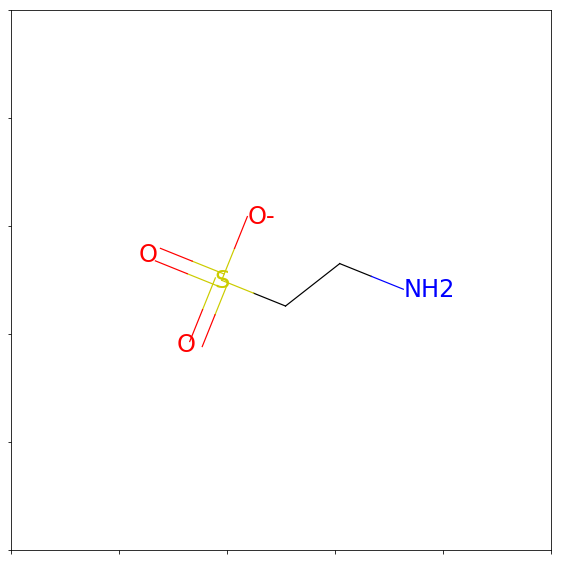

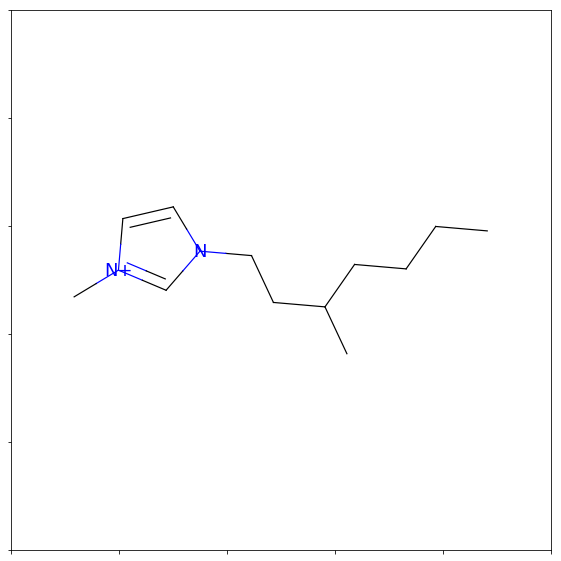

In [3]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(anion, genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = 0.99
    best = get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target, parent_candidates)
    return best
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation))
    
def get_fitness(anion, genes, target):
    cation = Chem.MolFromSmiles(genes)
    #anion = Chem.MolFromSmiles("[B-](F)(F)(F)F")
    prodmodel = load_data("density_prodmodel.pkl", pickleFile=True)
    model = prodmodel.Model
    deslist = prodmodel.Coef_data
    feature_vector=[]
    
    for item in deslist:

        if "anion" in item:
            with suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')\
                    [0]]).CalcDescriptors(anion)[0])
        elif "cation" in item:
            with suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')\
                [0]]).CalcDescriptors(cation)[0])          
        elif "Temperature_K" in item:
            feature_vector.append(298.15)
        elif "Pressure_kPa" in item:
            feature_vector.append(101.325)
        else:
            print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector-deslist.iloc[0].values)/deslist.iloc[1].values
    prediction = exp(model.predict(np.array(features_normalized).reshape(1,-1))[0])
    error = abs((prediction-target)/target)
    
    return 1-error

def show_ion(genes, target, mutation_attempts):
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("within 1%% of target density: %s (kg/m) " % target)
    

geneSet = generate_geneset()

df = load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]
df = df.loc[~df["name"].str.contains("azepinium", case=False)]
parent_candidates = df['smiles'].unique()


df = load_data("anionInfo.csv")
df = df['smiles'].unique()
ohPickMe = random.sample(range(df.shape[0]),1)
anion = Chem.MolFromSmiles(df[ohPickMe[0]])
print(df[ohPickMe[0]])
img = Draw.MolToMPL(anion)
target = random.sample(range(800,1500),1)[0]
target = 1300
print(target)
best = guess_password(target)
img = Draw.MolToMPL(best.Mol)

C[n+]1ccn(c1)CCO	0.8048780487804879	starting structure	0:00:00.001789
C[n+]1ccn(CCN)c1	0.8114754098360656	replace_atom	0:00:00.068216
CCn1cc[n+](C)c1	1.0	remove_atom	0:00:00.095587
number of atoms: 	8
mutation attempts: 	51


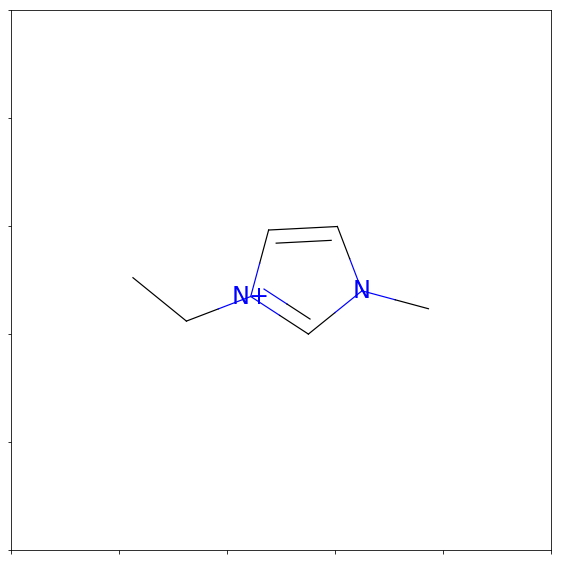

In [23]:
def guess_password(target):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(genes, target)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts):
        show_ion(genes, target, mutation_attempts)

    optimalFitness = get_fitness(target, target)
    best = get_best(fnGetFitness,\
        optimalFitness, geneSet, fnDisplay,\
                    fnShowIon, target, parent_candidates)
    
def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}\t{}".format(
    candidate.Genes, candidate.Fitness, mutation, timeDiff))
    
def get_fitness(genes, target):
    ms = [Chem.MolFromSmiles(target), Chem.MolFromSmiles(genes)]
    fps = [FingerprintMols.FingerprintMol(x) for x in ms]
    return DataStructs.FingerprintSimilarity(fps[0],fps[1])

def show_ion(genes, target, mutation_attempts):
    mol = Chem.MolFromSmiles(target)
    print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    

geneSet = generate_geneset()

df = load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]
df = df.loc[~df["name"].str.contains("azepinium", case=False)]
parent_candidates = df['smiles'].unique()

df = parent_candidates
ohPickMe = random.sample(range(df.shape[0]),1)
target = df[ohPickMe[0]]
guess_password(target)
img = Draw.MolToMPL(Chem.MolFromSmiles(target))

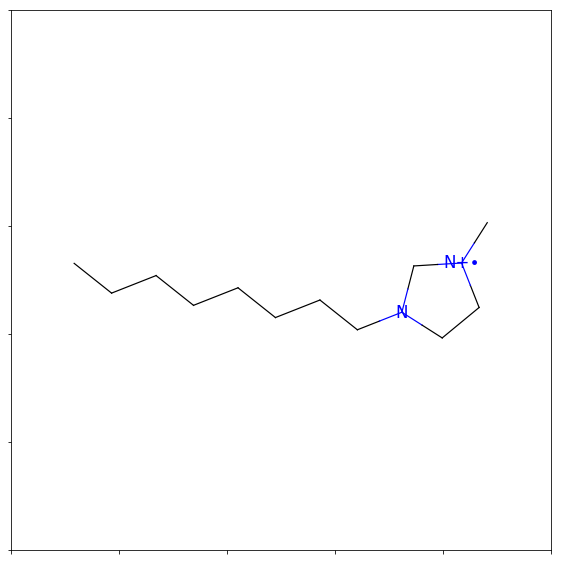

In [12]:
from rdkit.Chem import MolFromSmiles as mol
from rdkit.Chem.Draw import MolToMPL as img
a = img(mol(target))

In [144]:
geneSet.GetEntryDescription(random.sample(range(geneSet.GetNumEntries()), 1)[0])

'C[n+]ccn'

In [262]:
Chromosome("C1[n+]ccn1",0)

In [249]:
Chromosome(geneSet.GetEntryDescription(
    random.sample(range(geneSet.GetNumEntries()), 1)[0]), 0)

ArgumentError: Python argument types in
    RWMol.__init__(RWMol, NoneType)
did not match C++ signature:
    __init__(_object*, RDKit::ROMol, bool, int)
    __init__(_object*, RDKit::ROMol, bool)
    __init__(_object*)
    __init__(_object*, RDKit::ROMol)

In [58]:
atoms = [6, 7]
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
rdkitFrags = FragmentCatalog.FragCatParams(1, 5, fName)
customFrags = FragmentCatalog.FragCatalog(rdkitFrags)
fcgen = FragmentCatalog.FragCatGenerator()
m = Chem.MolFromSmiles(check_name("1-benzyl-3-methyl-1H-imidazol-3-ium"))
fcgen.AddFragsFromMol(m, customFrags)

geneSet = customFrags
newGene = Chromosome(geneSet.GetEntryDescription(
    random.sample(range(geneSet.GetNumEntries()), 1)[0]), 0)
oldGene = oldGene + newGene.Mol.GetNumAtoms()
combined = Chem.EditableMol(Chem.CombineMols(newGene.Mol,
                            childGenes.Mol))
combined.AddBond(0, oldGene, order=Chem.rdchem.BondType.SINGLE)
childGenes = combined.GetMol()

childGenes = Chromosome(Chem.MolToSmiles(childGenes), 0)

ArgumentError: Python argument types in
    RWMol.__init__(RWMol, NoneType)
did not match C++ signature:
    __init__(_object*, RDKit::ROMol, bool, int)
    __init__(_object*, RDKit::ROMol, bool)
    __init__(_object*)
    __init__(_object*, RDKit::ROMol)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


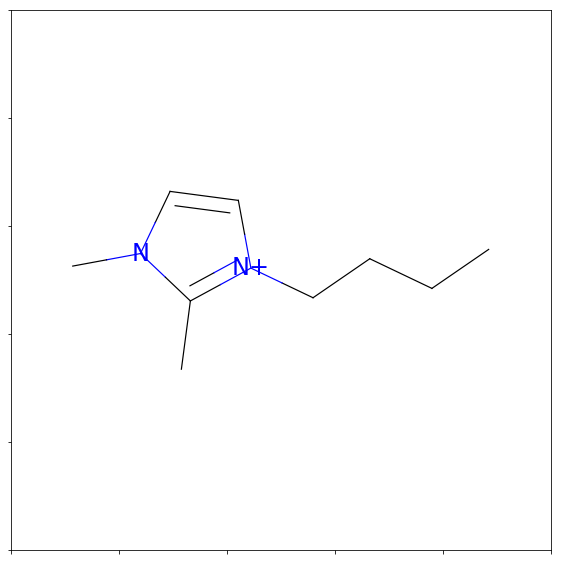

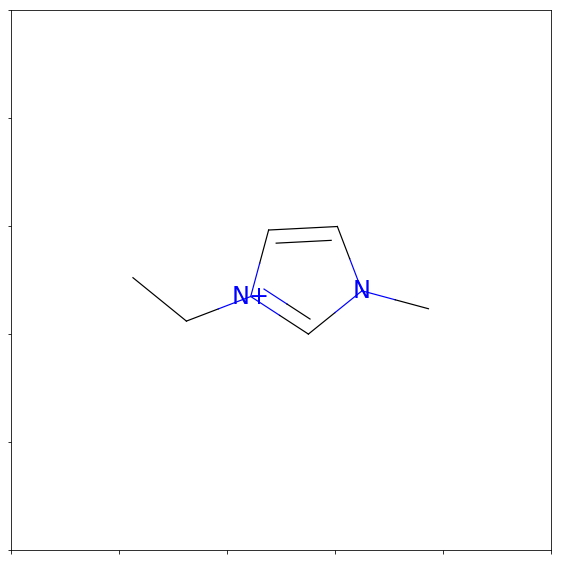

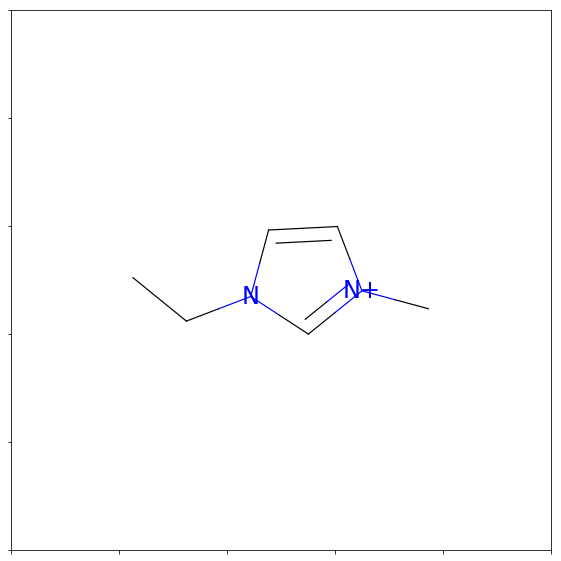

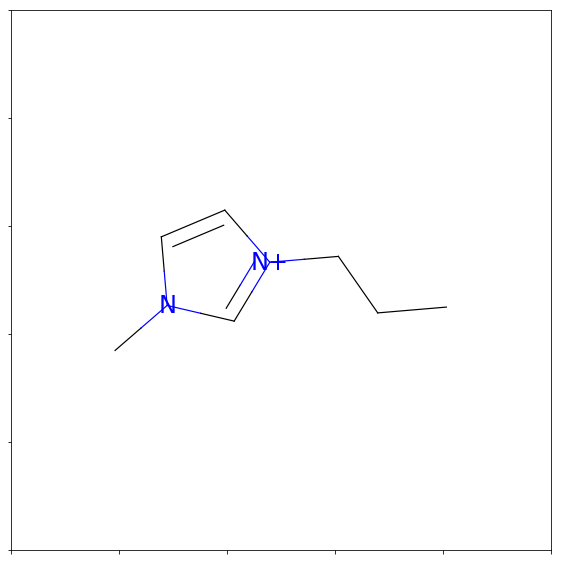

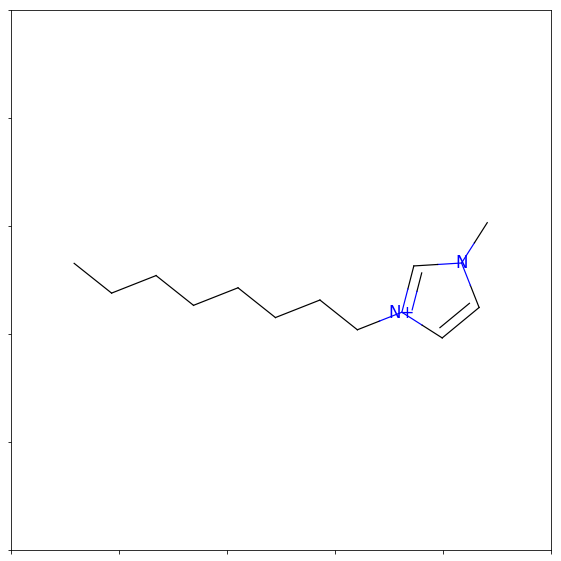

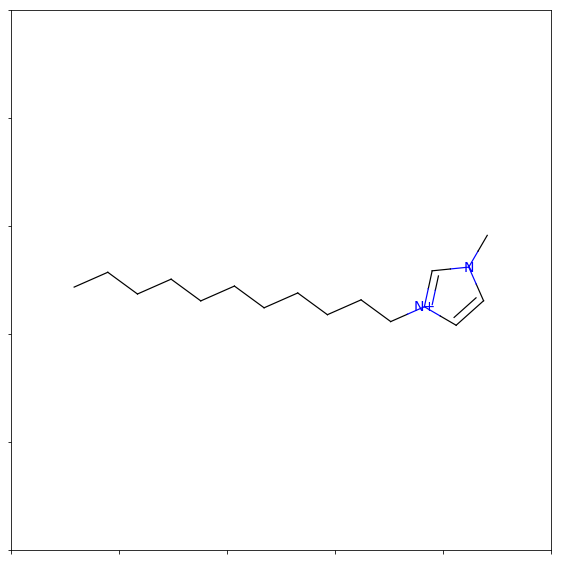

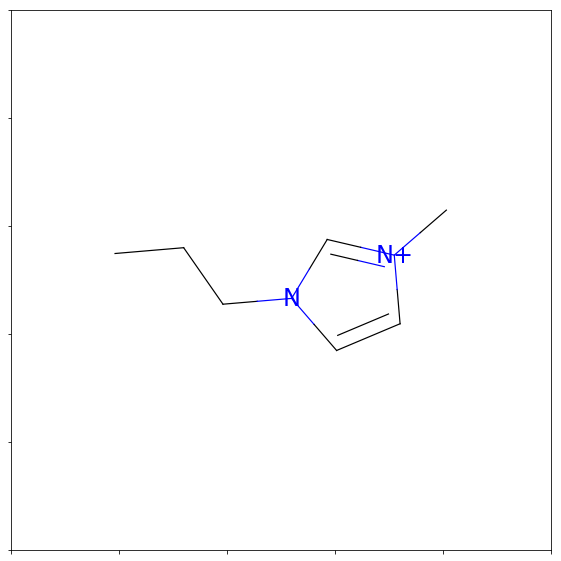

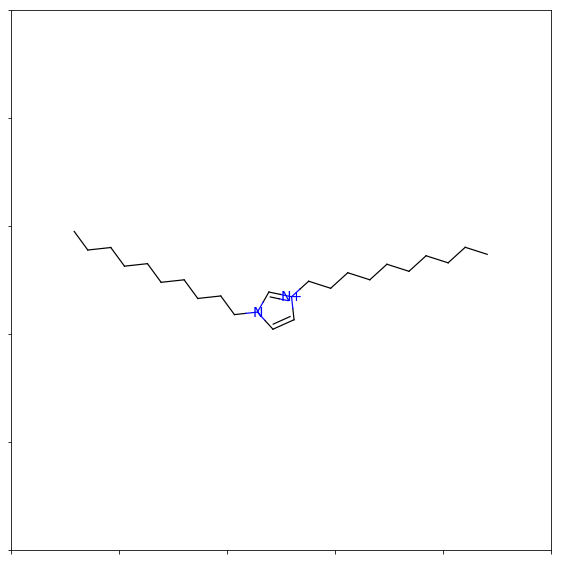

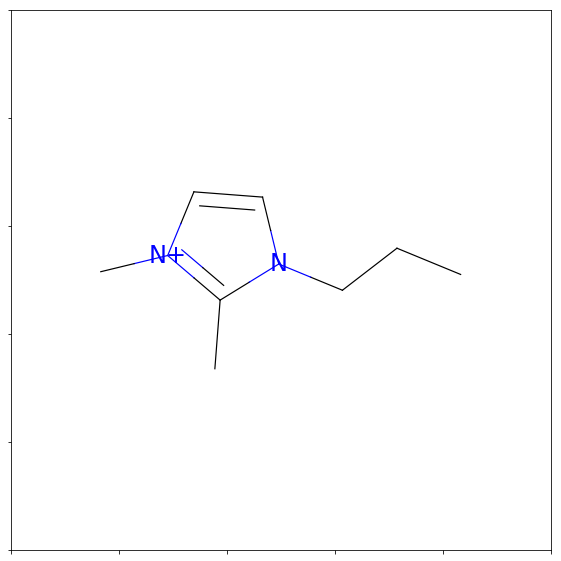

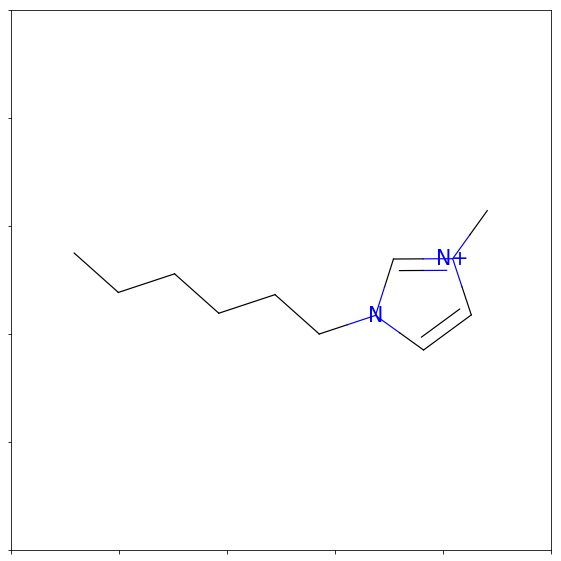

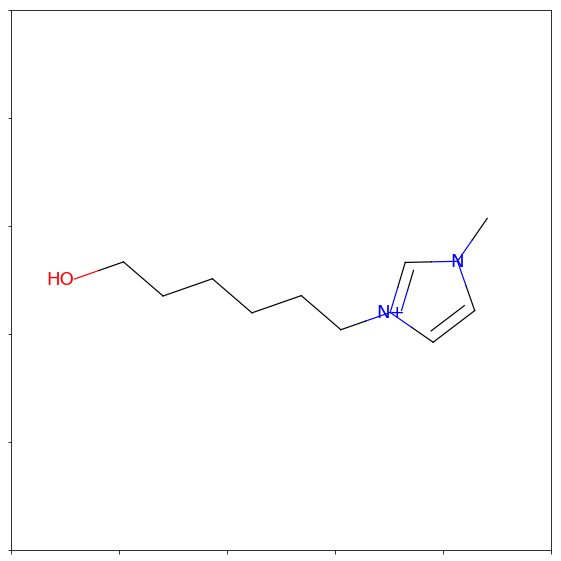

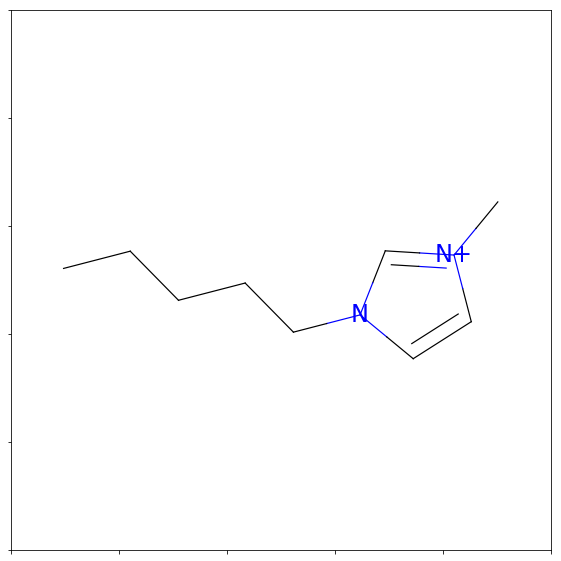

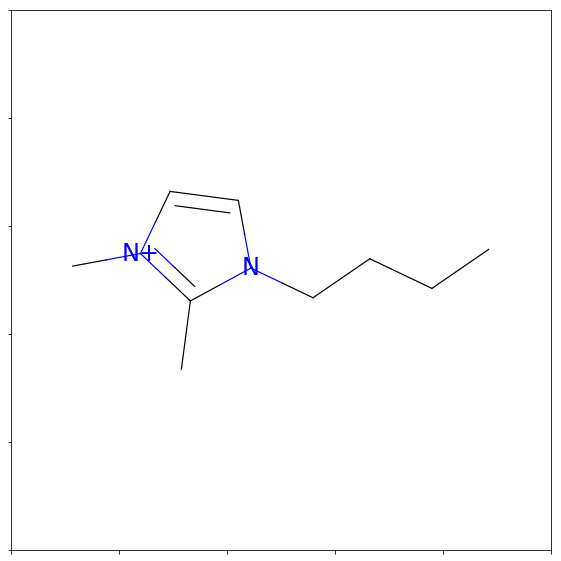

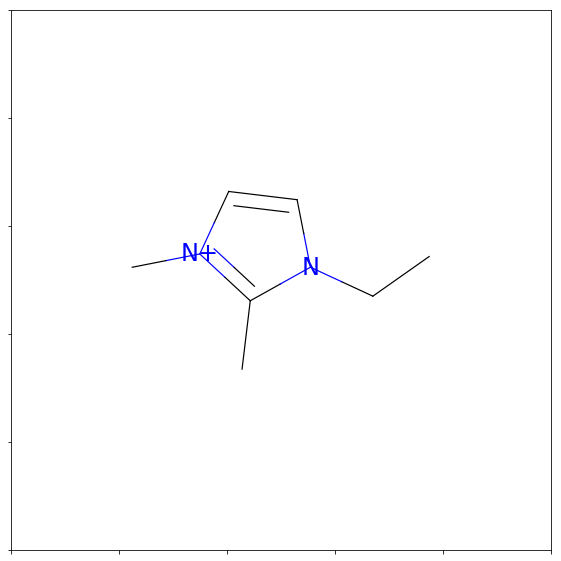

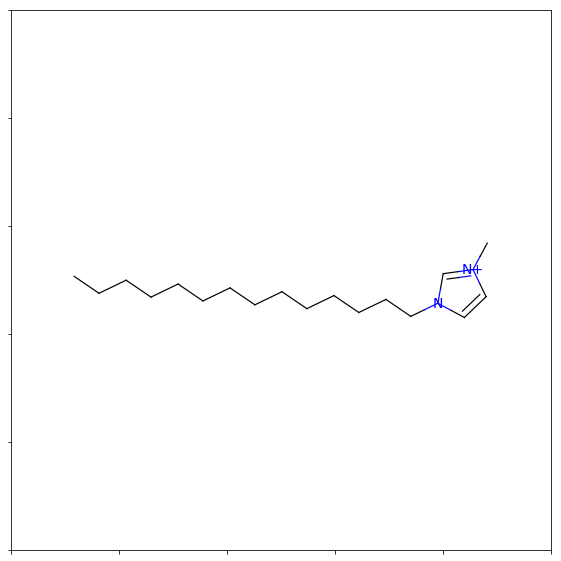

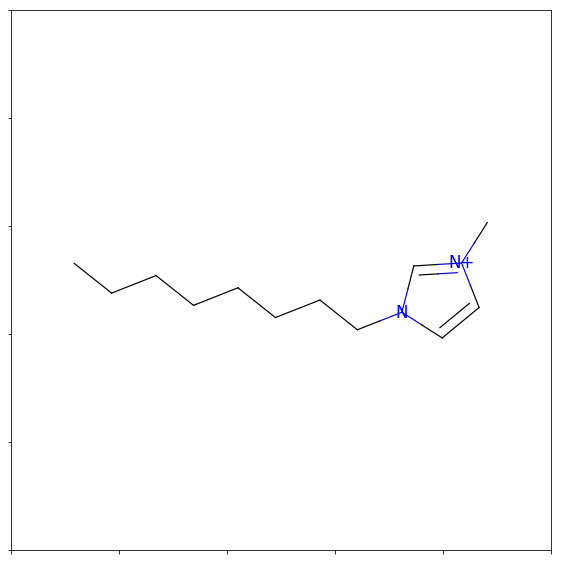

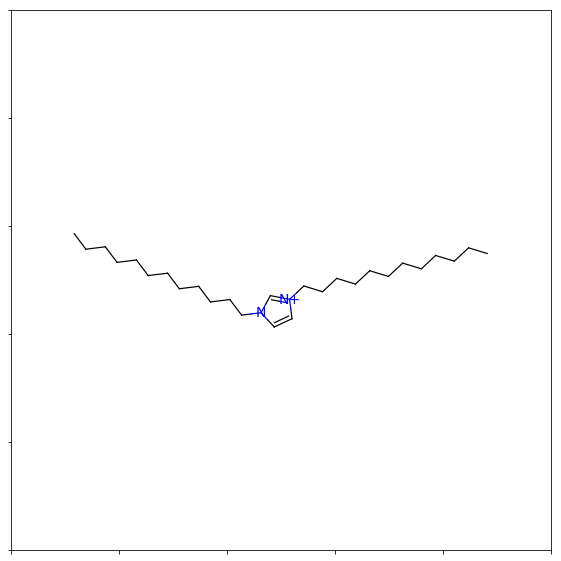

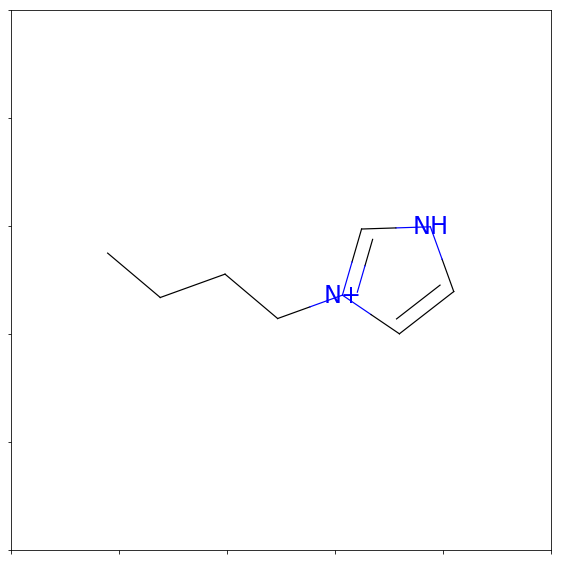

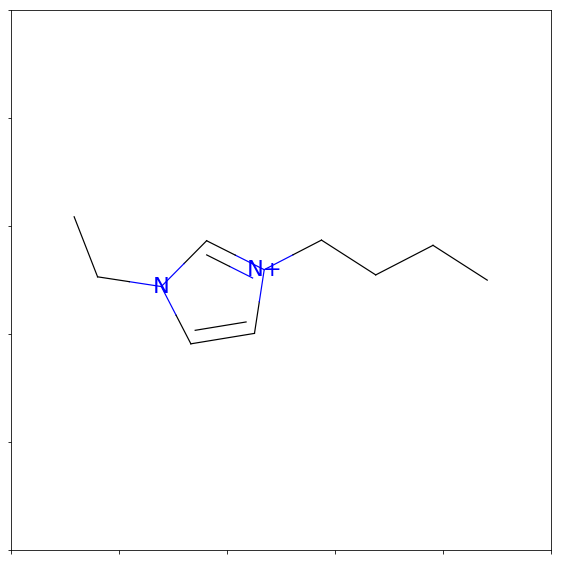

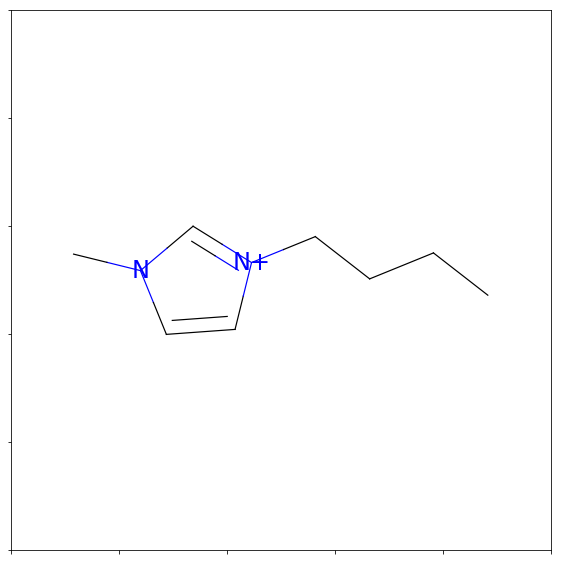

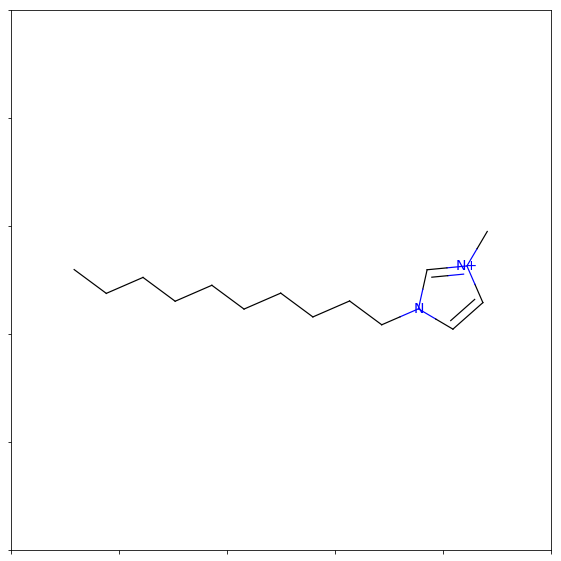

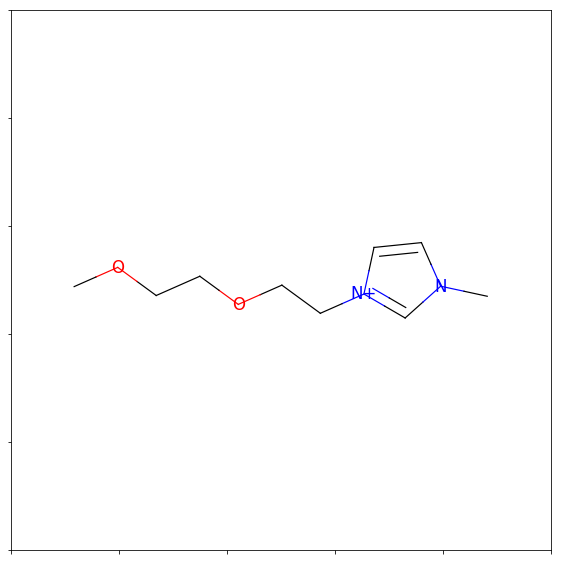

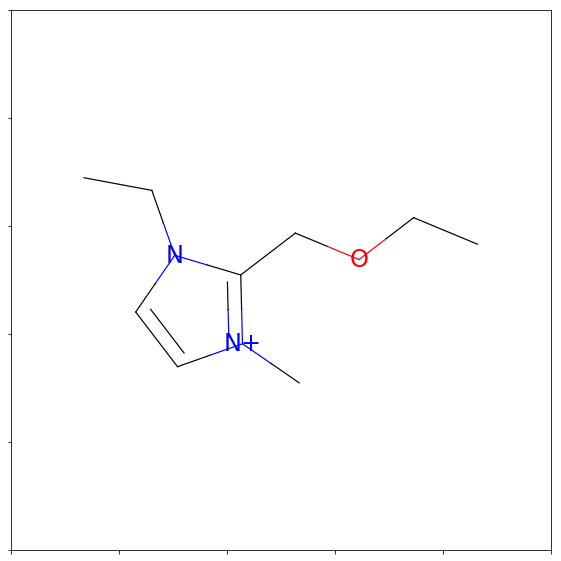

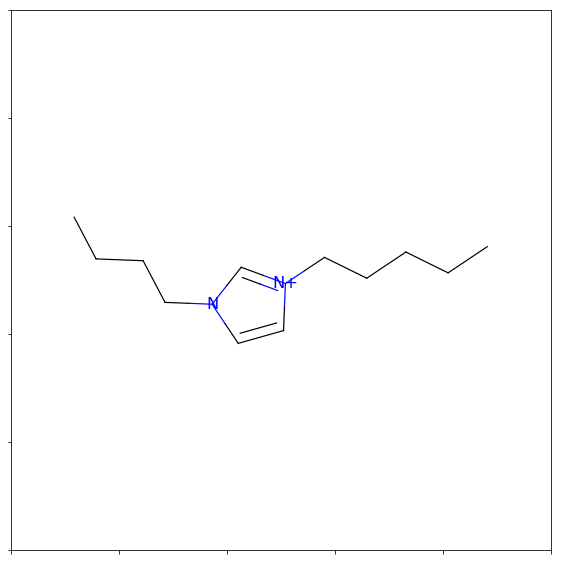

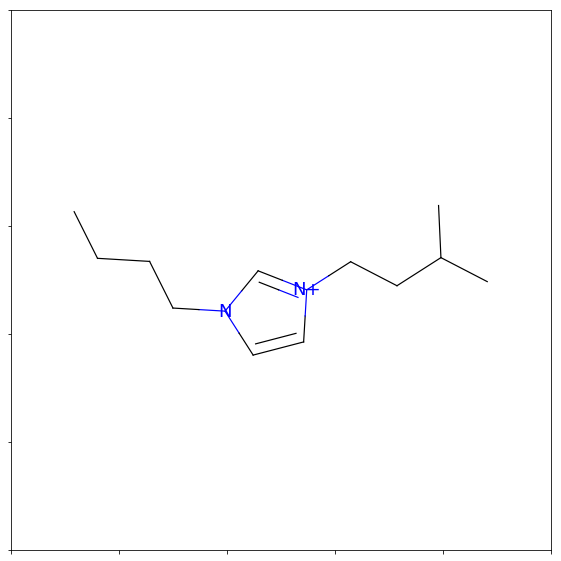

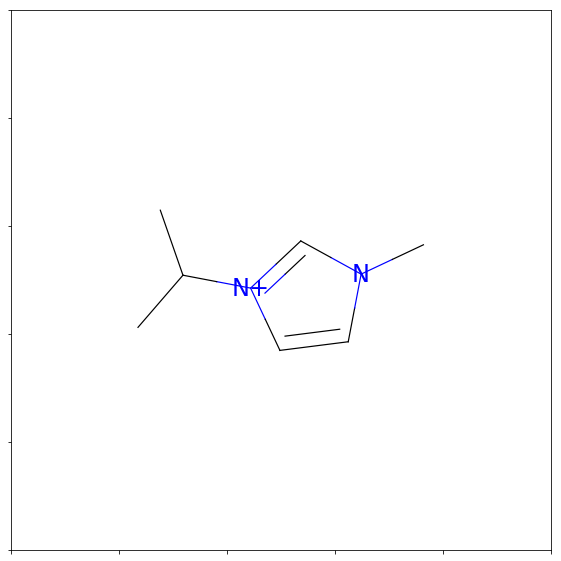

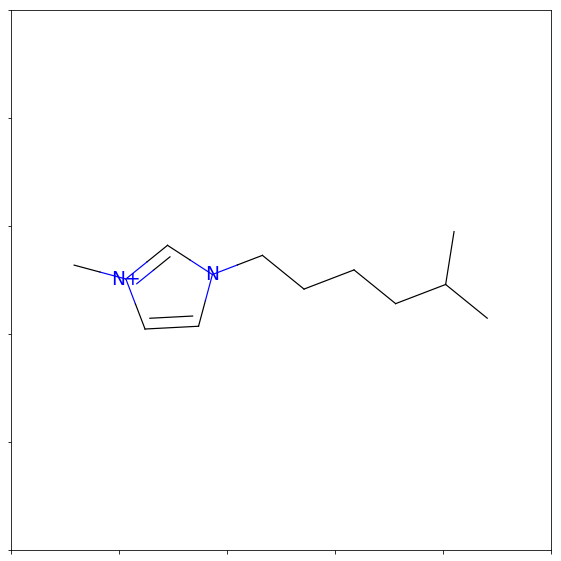

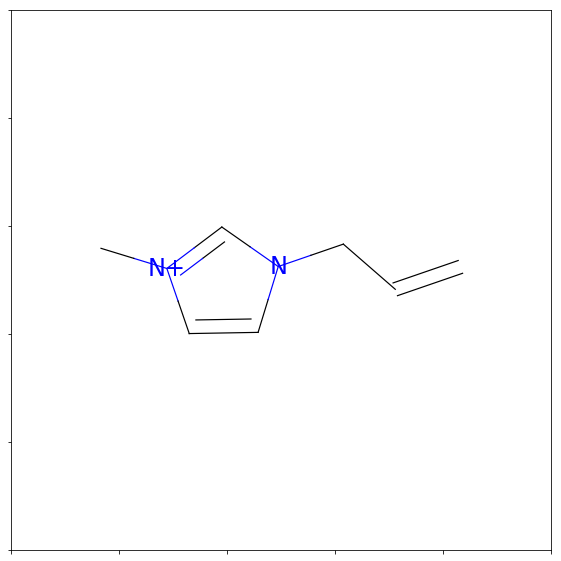

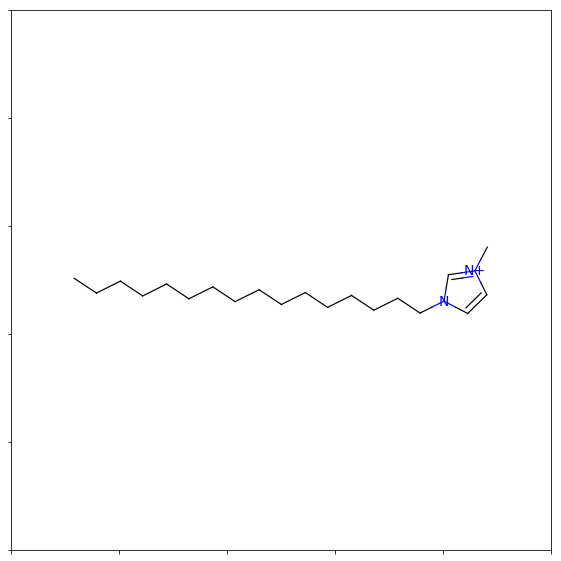

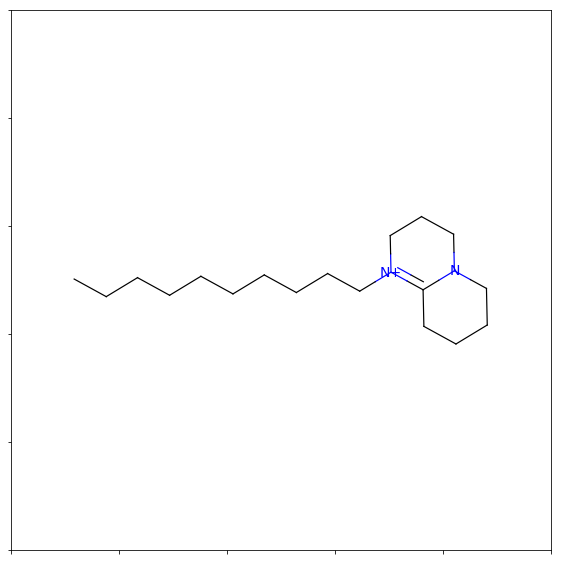

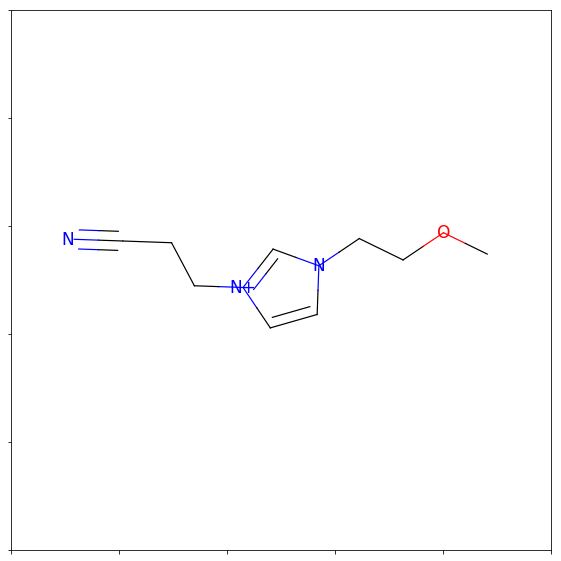

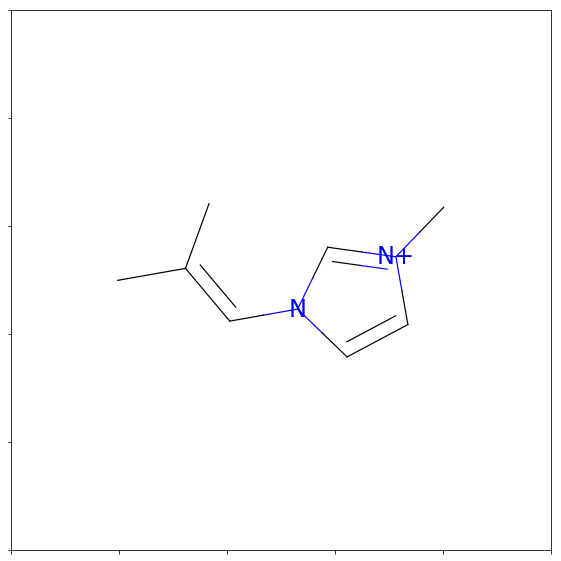

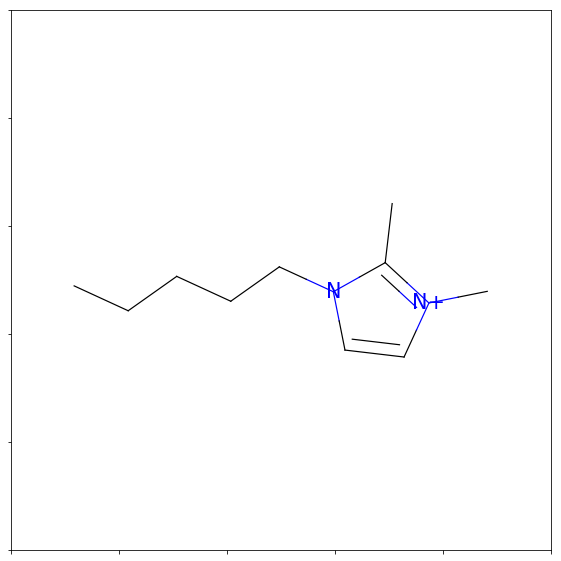

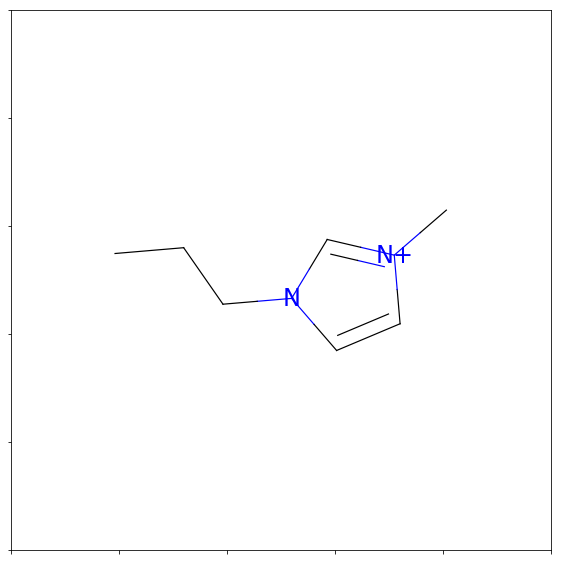

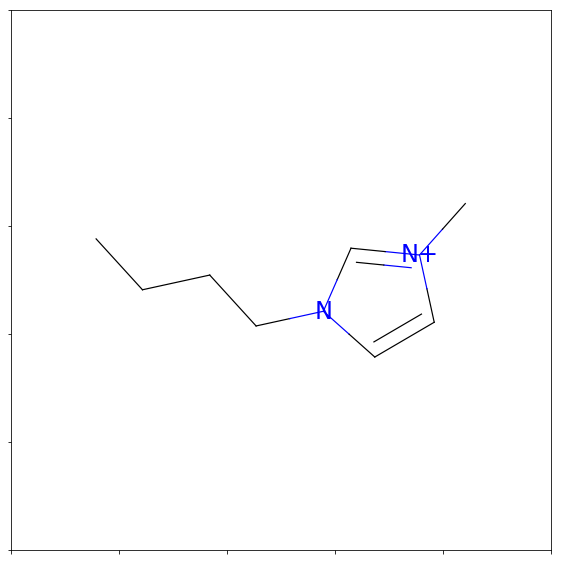

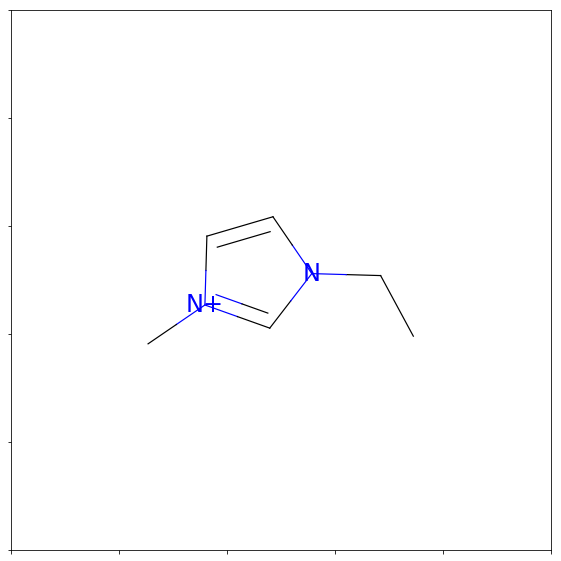

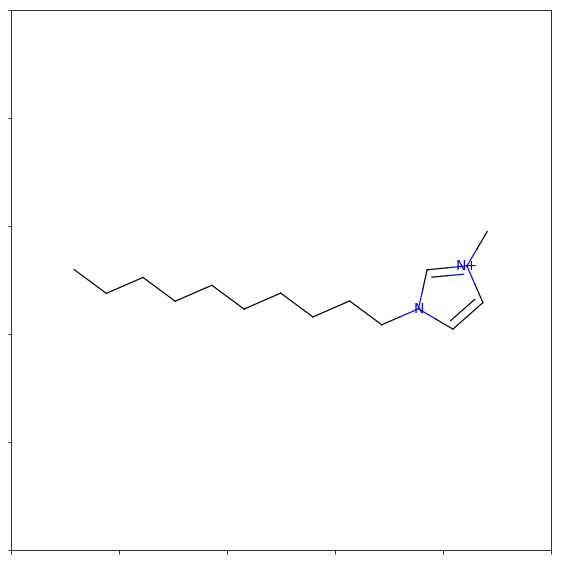

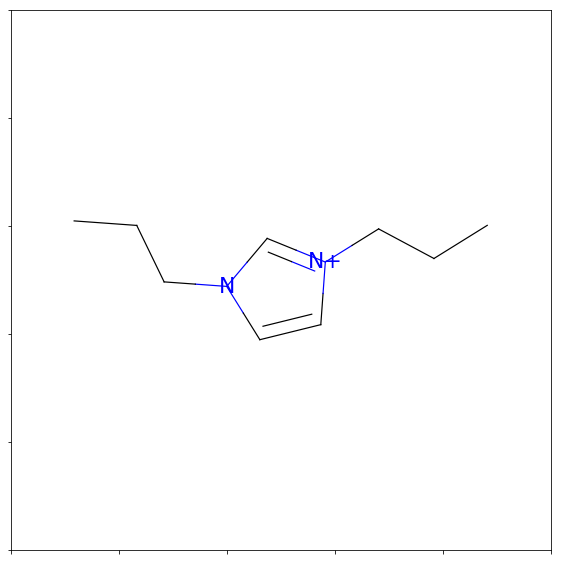

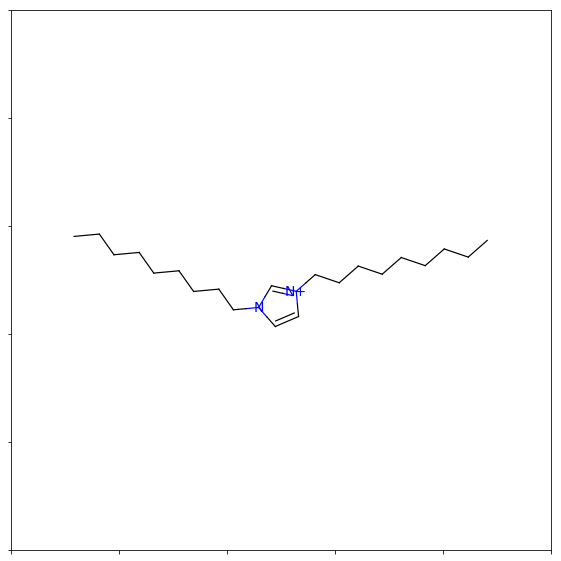

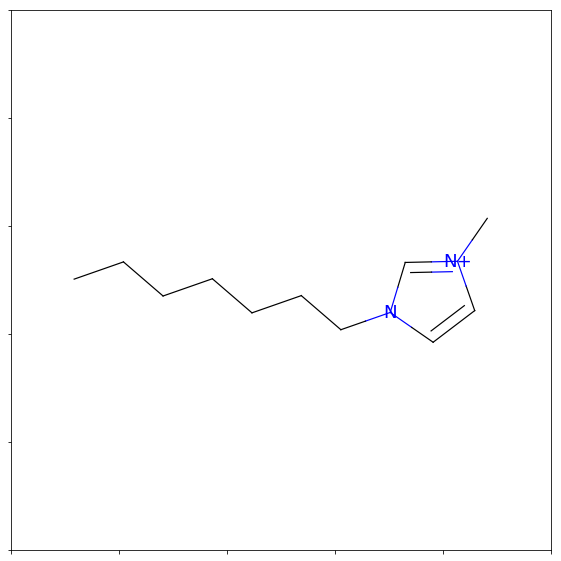

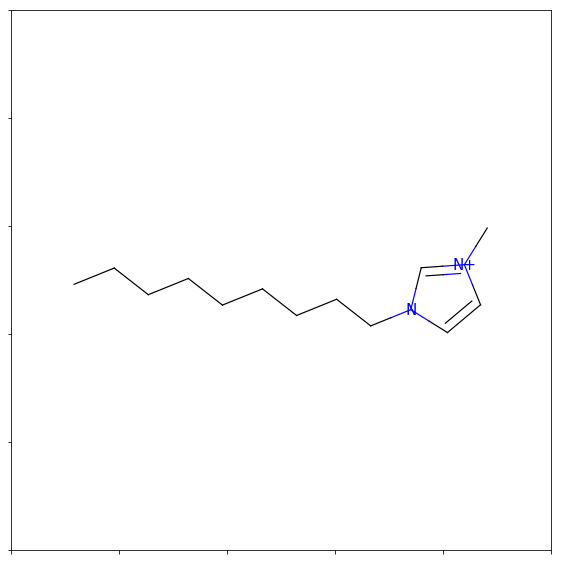

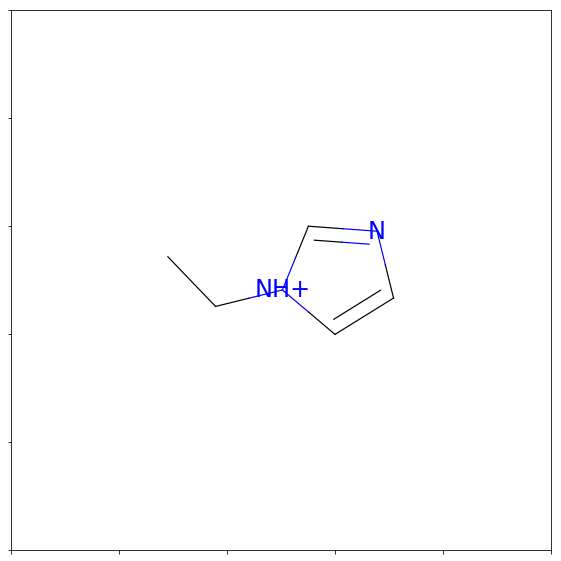

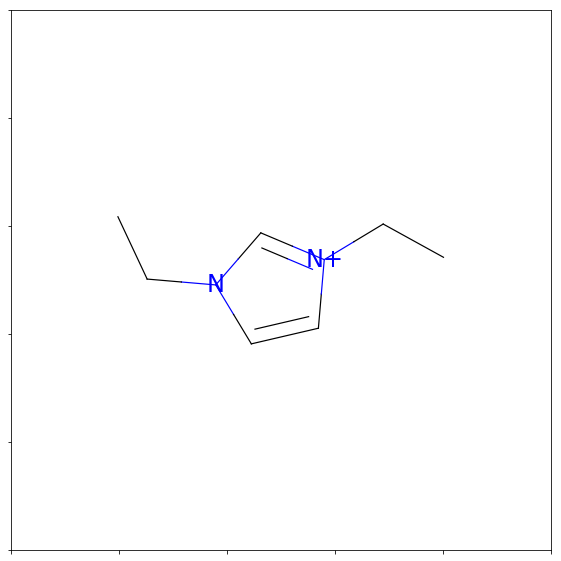

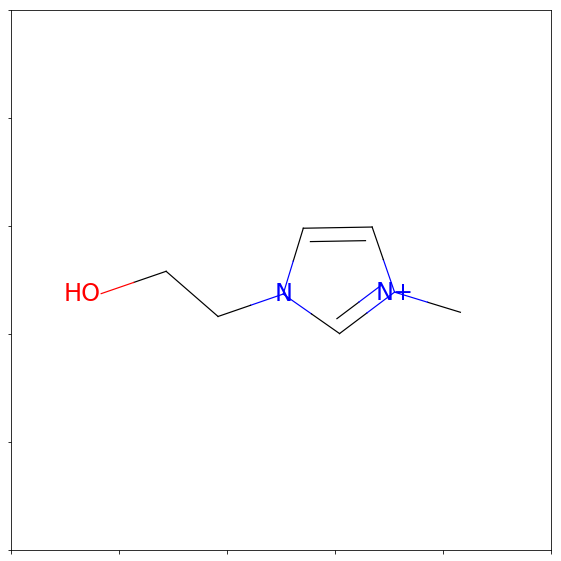

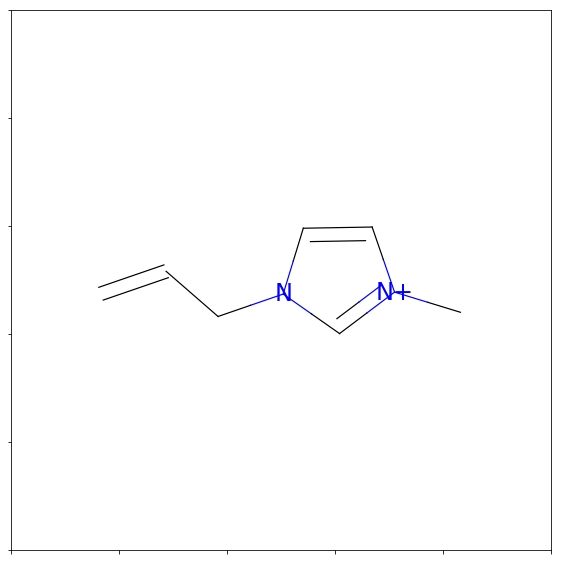

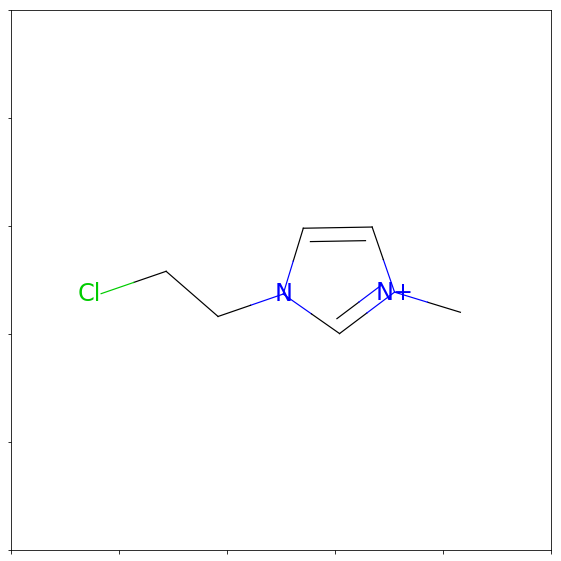

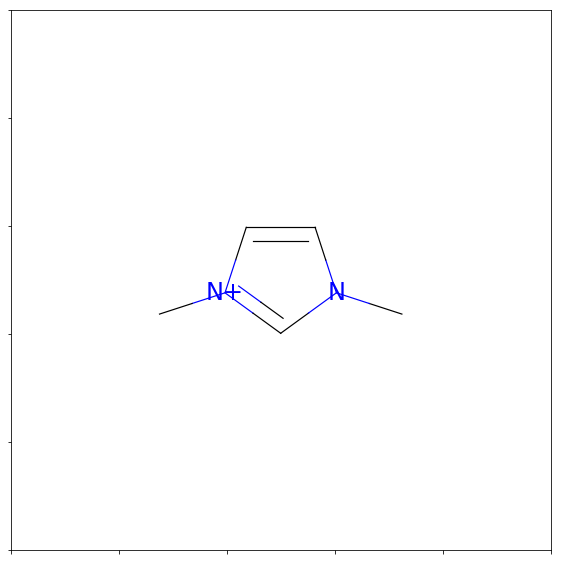

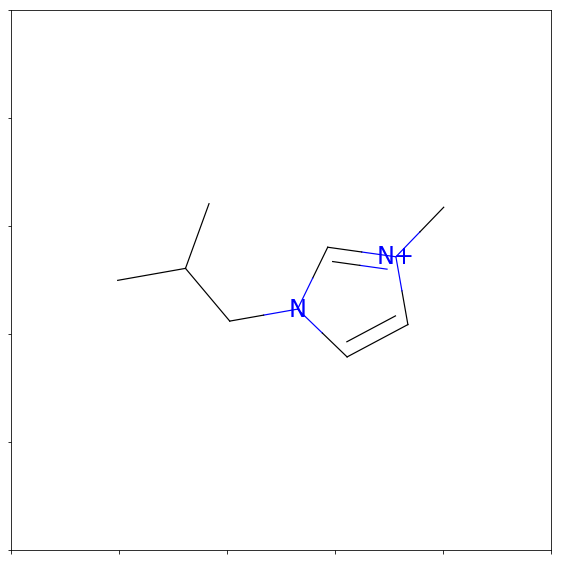

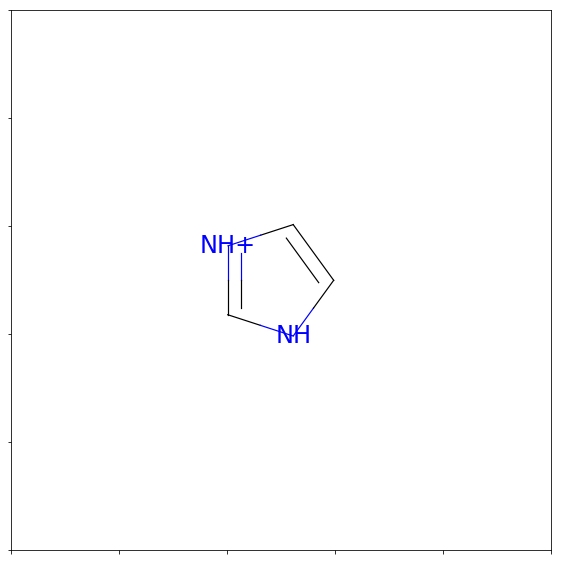

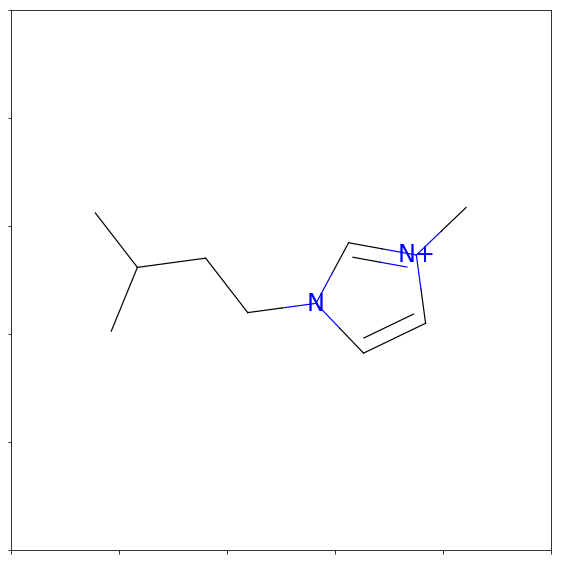

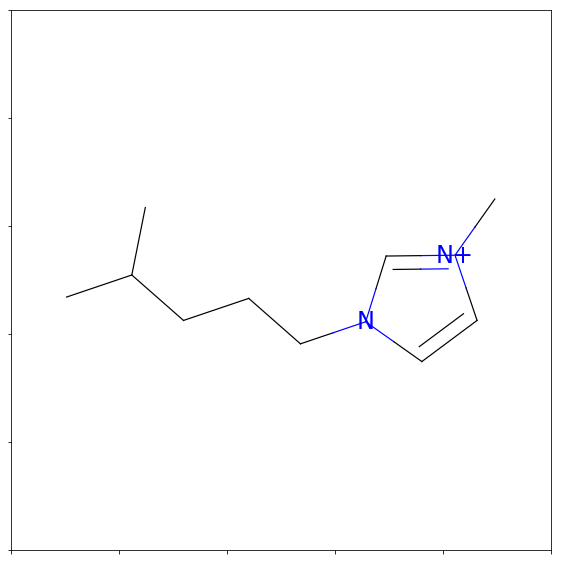

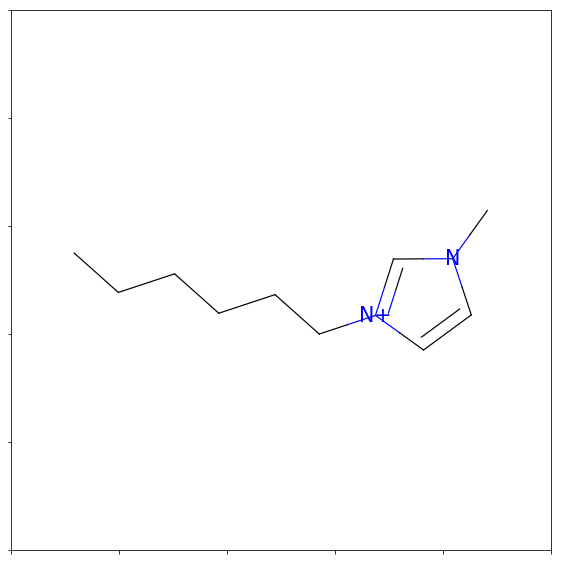

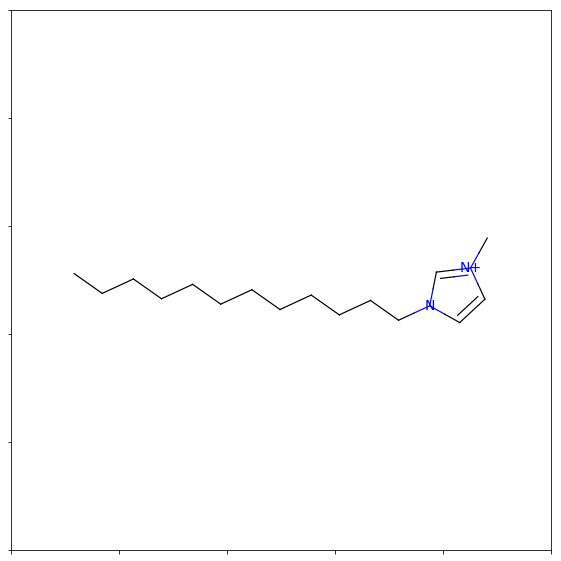

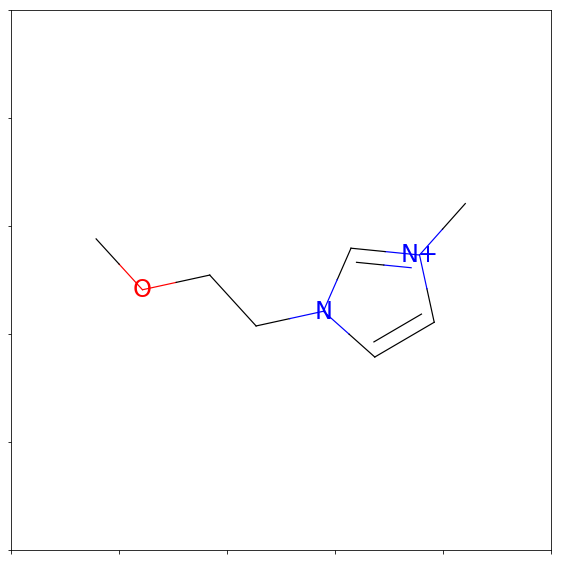

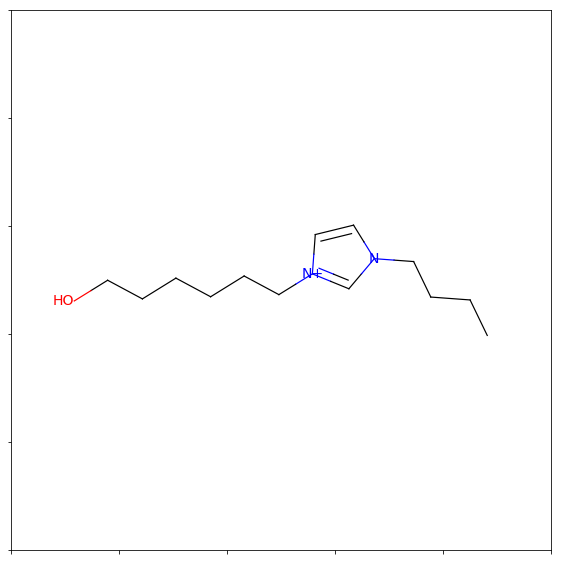

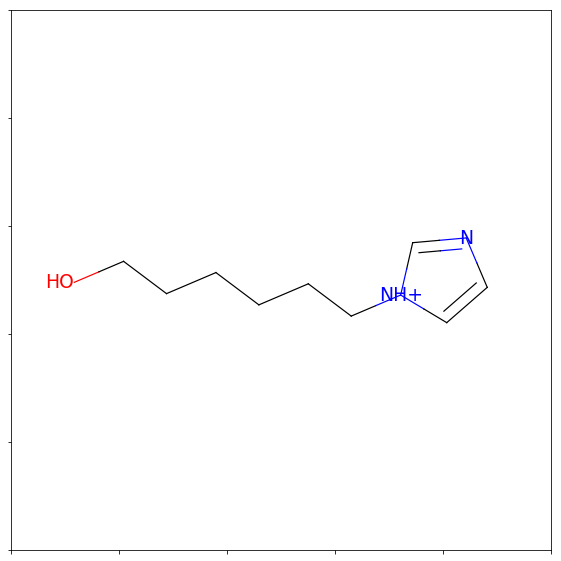

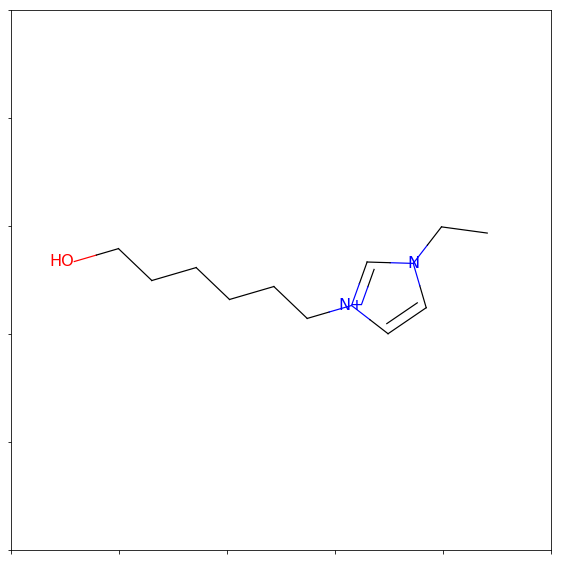

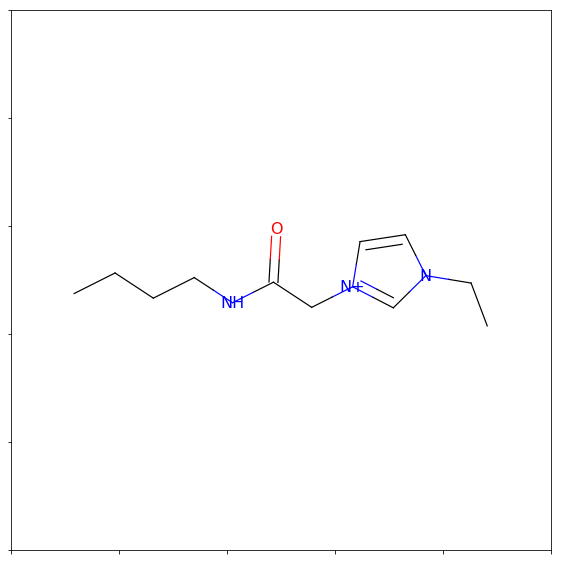

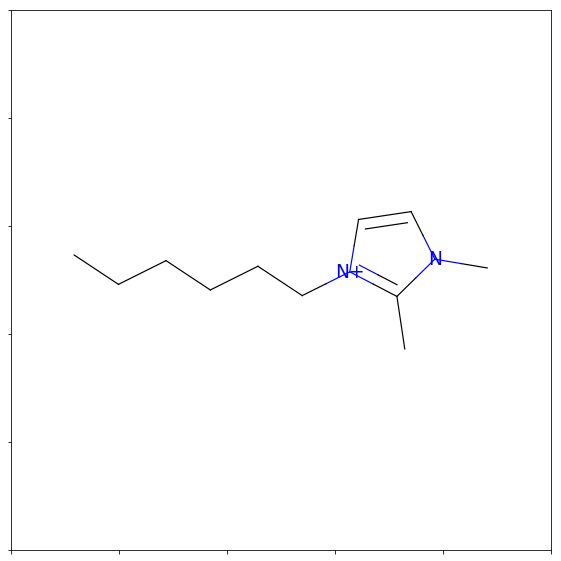

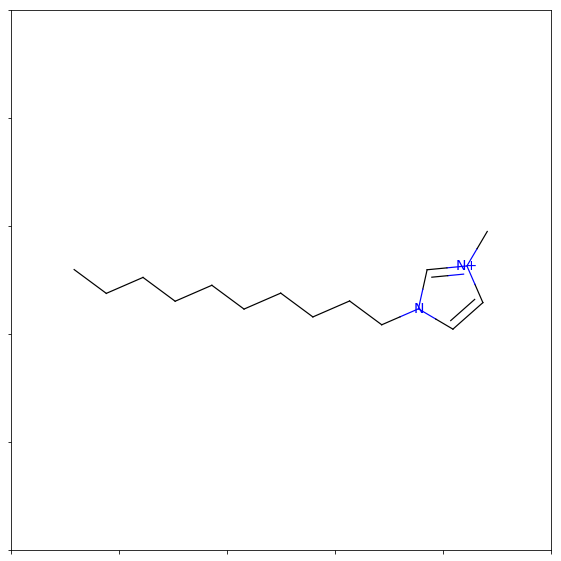

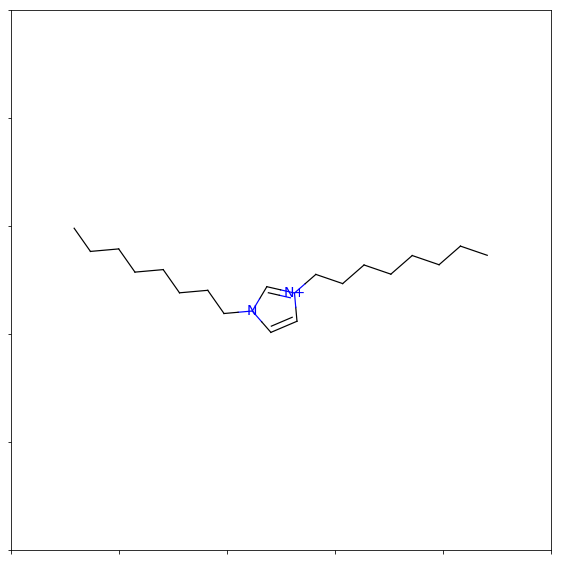

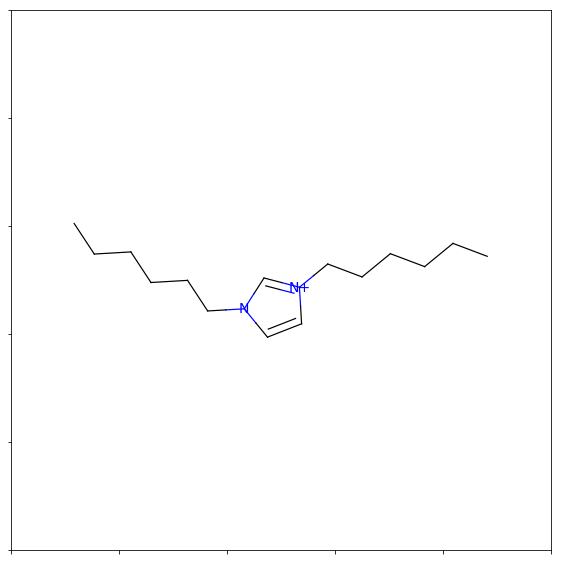

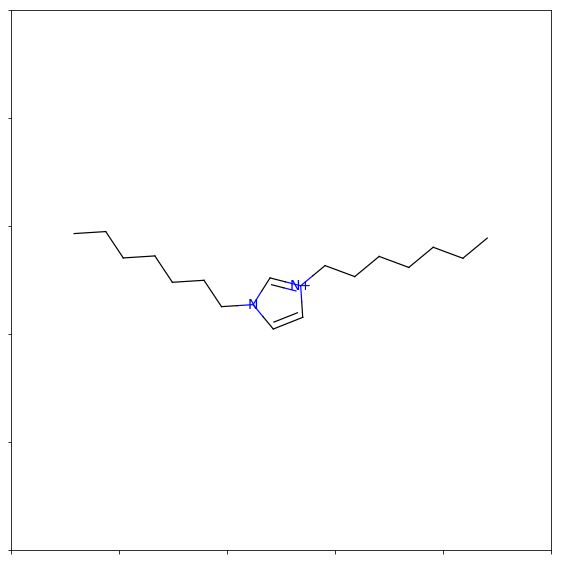

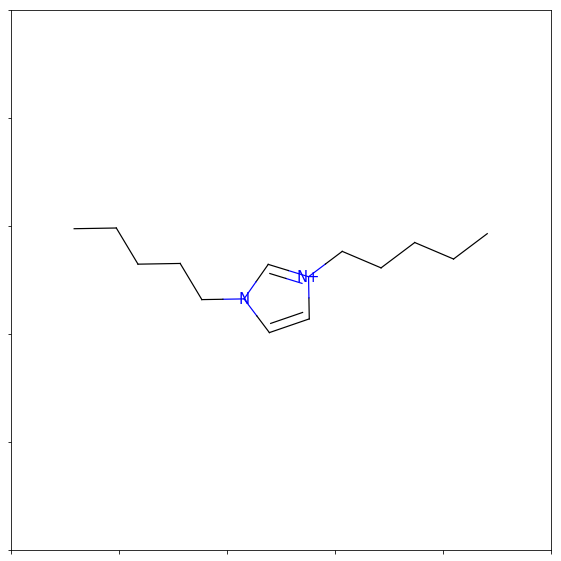

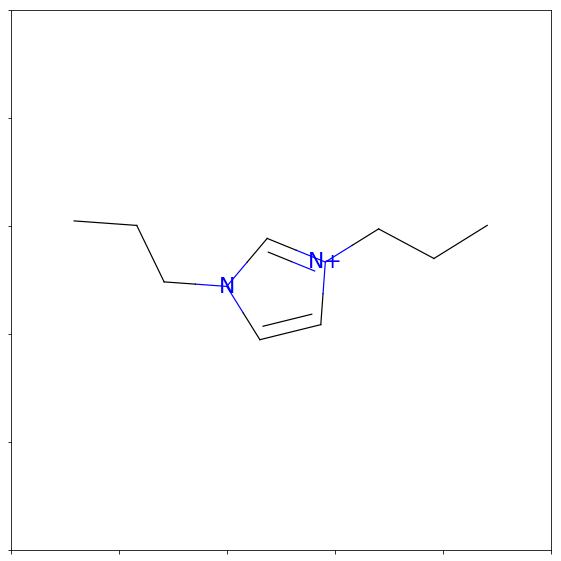

In [278]:
df = load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]
df = df.loc[~df["name"].str.contains("azepinium", case=False)]
df = df['smiles'].unique()
for i in range(df.shape[0]):
    Draw.MolToMPL(Chem.MolFromSmiles(df[i]))

In [9]:
from salty import check_name
df = load_data("cationInfo.csv")
df = df.loc[df["name"].str.contains("imid", case=False)]
df = df.loc[~df["name"].str.contains("phenyl", case=False)]
df = df.loc[~df["name"].str.contains("benzyl", case=False)]
df = df.loc[~df["name"].str.contains("azido", case=False)]
df = df.loc[~df["name"].str.contains("cyan", case=False)]
df = df.loc[~df["name"].str.contains("benz", case=False)]
df = df.loc[~df["name"].str.contains("cyclo", case=False)]
df = df.loc[~df["name"].str.contains("sulf", case=False)]

df = df['smiles'].unique()
df


array(['CCCC[n+]1cc[n](c1(C))C', 'CC[n+]1cn(cc1)C', 'CCn1c[n+](cc1)C',
       'Cn1c[n+](cc1)CCC', 'CCCCCCCC[n+]1cc[n](c1)C',
       'CCCCCCCCCCC[n+]1ccn(c1)C', 'CCCn1cc[n+](c1)C',
       'CCCCCCCCCCn1cc[n+](c1)CCCCCCCCCC', 'CCCn1cc[n+](c1C)C',
       'CCCCCCn1cc[n+](c1)C', 'OCCCCCC([n+]1ccn(c1)C)',
       'c1c[n+](cn1CCCCC)C', 'CCCCn1cc[n+](c1C)C', 'CCn1cc[n+](c1C)C',
       'CCCCCCCCCCCCCCn1cc[n+](c1)C', 'CCCCCCCCn1cc[n+](c1)C',
       'CCCCCCCCCCCCn1cc[n+](c1)CCCCCCCCCCCC', 'CCCC[n+]1cc[nH]c1',
       'c1c[n+](cn1CC)CCCC', 'C1=C[N+](CCCC)=CN1C',
       'c1c[n+](cn1CCCCCCCCCC)C', '[N+](CCOCCOC)1=C(N(C)C(=C1))',
       'C1=C[N+](C)=C(COCC)N1CC', 'c1c[n+](cn1CCCC)CCCCC',
       'c1c[n+](cn1CCCC)CCC(C)C', 'c1cn(c([n+]1C(C)(C)))C',
       'c1cn(c([n+]1C))CCCCC(C)C', 'c1cn(c([n+]1C))CC=C',
       'CCCCCCCCCCCCCCCCn1cc[n+](c1)C', 'C1CCC2=[N+](CCCCCCCCCC)CCCN2C1',
       'C2=CN(C=[N+]2CCC#N)CCOC', 'C1=C[N+](C)=CN1C=C(C)C',
       'C1=C[N+](C)=C(C)N1CCCCC', 'C1=C[N+](C)=CN1CCC',
       'CCCCn

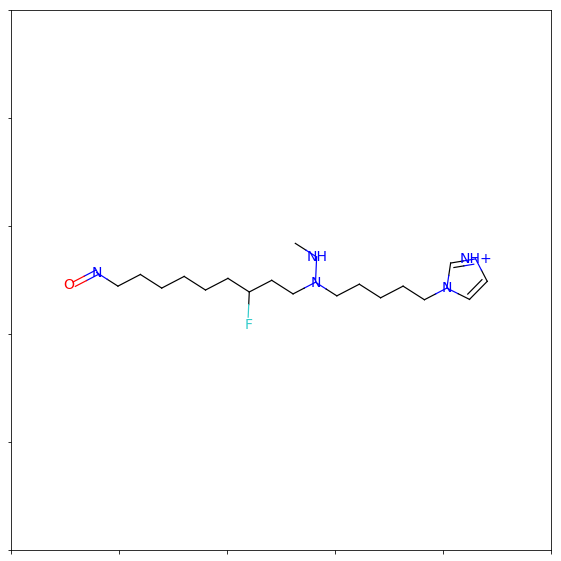

In [9]:
def remove_custom_fragment(childGenes, GeneSet, oldGene):
    geneSet = GeneSet.CustomFrags
    newGene = Chromosome(geneSet.GetEntryDescription(
        random.sample(range(geneSet.GetNumEntries()), 1)[0]), 0)
    try:
        truncate = Chem.DeleteSubstructs(childGenes.Mol, newGene.Mol)
        childGenes = truncate
        childGenes = Chromosome(Chem.MolToSmiles(childGenes), 0)
        return childGenes
    except BaseException:
        return 0
img = Draw.MolToMPL(Chem.MolFromSmiles("CNN(CCCCCN1C=C[NH+]=C1)CCC(F)CCCCCCN=O"))

In [7]:
import salty
salty.check_name("c1cc(cc(c1)S(=O)(=O)[O-])C(=O)O")

'3-sulfobenzoate'

(<matplotlib.figure.Figure at 0x7fd8eee00ac8>, 0.30555555555555547)

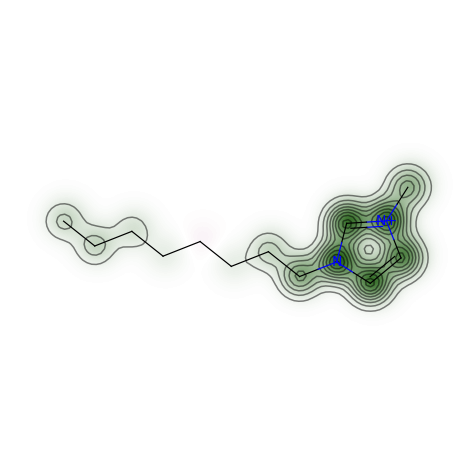

In [27]:
geneSet = genetic.generate_geneset()
df = genetic.load_data("saltInfo.csv")
df = df.loc[df["cation_name"].str.contains("imid", case=False)]
df = df['cation_SMILES'].unique()
ohPickMe = random.sample(range(df.shape[0]),2)
target = Chem.MolFromSmiles(df[ohPickMe[0]])
candidate = Chem.MolFromSmiles(df[ohPickMe[1]])
%matplotlib inline
SimilarityMaps.GetSimilarityMapForFingerprint(candidate,\
        target,SimilarityMaps.GetMorganFingerprint)